# example_mms_ebfields
## author: Louis Richard
### Plots E and B time series and of burst mode electric field in GSE coordinates and field-aligned coordinates. Plots spectrograms of paralleland perpendicular electric fields and fluctuating magnetic field.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from astropy import constants
from pyrfu.mms import get_data
from pyrfu.plot import plot_line, plot_spectr
from pyrfu.pyrf import wavelet, norm, convert_fac, filt, resample, ts_scalar

#### Define time interval

In [2]:
tint = ["2015-10-30T05:15:20.000", "2015-10-30T05:16:20.000"]

#### Define spacecraft index

In [3]:
ic = 1

#### Load data

In [4]:
b_xyz = get_data("b_gse_fgm_brst_l2", tint, ic)
b_mag = norm(b_xyz)
e_xyz = get_data("e_gse_edp_brst_l2", tint, ic)
b_scm = get_data("b_gse_scm_brst_l2", tint, ic)
n_e =  get_data("ne_fpi_brst_l2", tint, ic)

Loading mms1_fgm_b_gse_brst_l2...
Loading mms1_edp_dce_gse_brst_l2...
Loading mms1_scm_acb_gse_scb_brst_l2...
Loading mms1_des_numberdensity_brst...


#### Rotate E and B into field-aligned coordinates

In [5]:
e_xyzfac = convert_fac(e_xyz, b_xyz,[1, 0, 0])
b_scmfac = convert_fac(b_scm, b_xyz,[1, 0, 0])

#### Bandpass filter E and B waveforms

In [6]:
fmin, fmax = [.5, 1000]  # Hz
e_xyzfac_hf = filt(e_xyzfac, fmin, 0, 3)
e_xyzfac_lf = filt(e_xyzfac, 0, fmin, 3)
b_scmfac_hf = filt(b_scmfac, fmin, 0, 3)

#### Wavelet transforms

In [7]:
nf = 100
e_cwt, b_cwt = [wavelet(field, nf=nf, f=[fmin, fmax]) for field in [e_xyzfac, b_scm]]

#### Compress wavelet transform

In [8]:
nc = 100

# Number of frequencies
nf = e_cwt.x.shape[1]

idxs = np.arange(int(nc / 2), len(e_cwt.time) - int(nc / 2), step=nc).astype(int)

e_cwt_times = e_cwt.time[idxs]

e_cwt_x, e_cwt_y, e_cwt_z = [np.zeros((len(idxs), nf)) for _ in range(3)]

for i, idx in enumerate(idxs):
    e_cwt_x[i, :] = np.squeeze(np.nanmean(e_cwt.x[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))
    e_cwt_y[i, :] = np.squeeze(np.nanmean(e_cwt.y[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))
    e_cwt_z[i, :] = np.squeeze(np.nanmean(e_cwt.z[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))

options = dict(coords=[e_cwt_times, e_cwt.frequency], dims=["time", "frequency"])
e_perp_cwt = xr.DataArray(e_cwt_x + e_cwt_y, **options)
e_para_cwt = xr.DataArray(e_cwt_z, **options)

# Number of frequencies
nf = b_cwt.x.shape[1]

idxs = np.arange(int(nc / 2), len(b_cwt.time) - int(nc / 2), step=nc).astype(int)

b_cwt_times = b_cwt.time[idxs]

b_cwt_x, b_cwt_y, b_cwt_z = [np.zeros((len(idxs), nf)) for _ in range(3)]

for i, idx in enumerate(idxs):
    b_cwt_x[i, :] = np.squeeze(np.nanmean(b_cwt.x[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))
    b_cwt_y[i, :] = np.squeeze(np.nanmean(b_cwt.y[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))
    b_cwt_z[i, :] = np.squeeze(np.nanmean(b_cwt.z[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))

options = dict(coords=[b_cwt_times, b_cwt.frequency], dims=["time", "frequency"])
b_cwt = xr.DataArray(b_cwt_x + b_cwt_y + b_cwt_z, **options)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


#### Compute characteristic frequencies

In [ ]:
me = constants.m_e.value
mp = constants.m_p.value
qe = constants.e.value
eps0 = constants.eps0.value
mu0 = constants.mu0.value
mp_me = mp / me
b_si = b_mag * 1e-9
w_pe = np.sqrt(resample(n_e, b_xyz) * 1e6 * qe ** 2 /(me * eps0))
w_ce = qe * b_si / me
w_pp = np.sqrt(resample(n_e, b_xyz) * 1e6 * qe ** 2/ (mp * eps0))
f_ce = w_ce / (2 * np.pi)
f_pe = w_pe / (2 * np.pi)
f_cp = f_ce / mp_me
f_pp = w_pp / (2 * np.pi)
f_lh = np.sqrt(f_cp * f_ce /(1 + f_ce ** 2. / f_pe ** 2) + f_cp ** 2)

#### Plot

In [ ]:
legend_options = dict(ncol=4, loc="upper right", frameon=True)
spectr_options = dict(yscale="log", cscale="log", cmap="Spectral_r")

In [ ]:
%matplotlib notebook
f, axs = plt.subplots(7, sharex="all", figsize=(6.5,10))
f.subplots_adjust(left=.15, right=.85, hspace=0)
plot_line(axs[0], b_xyz)
plot_line(axs[0], b_mag)

axs[0].set_ylabel("$B$ [nT]")
axs[0].set_ylim([-50, 60])
axs[0].legend(["$B_{x}$","$B_{y}$","$B_{z}$","$|B|$"], **legend_options)

plot_line(axs[1], e_xyzfac_lf)
axs[1].set_ylabel("$E$ [mV m$^{-1}$]")
axs[1].legend(["$E_{\\perp 1}$","$E_{\\perp 2}$","$E_{||}$"], **legend_options)

plot_line(axs[2], e_xyzfac_hf)
axs[2].set_ylabel("$E$ [mV m$^{-1}$]")
axs[2].legend(["$E_{\\perp 1}$","$E_{\\perp 2}$","$E_{||}$"], **legend_options)

axs[3], caxs3 = plot_spectr(axs[3], e_perp_cwt, **spectr_options)
axs[3].set_ylabel("$f$ [Hz]")
caxs3.set_ylabel("$E_{\\perp}^2$" + "\n" + "$mV^2 m^{-2} Hz^{-1}$")
plot_line(axs[3], f_lh, "k")
plot_line(axs[3], f_ce, "tab:red")
plot_line(axs[3], f_pp, "tab:blue")
axs[3].legend(["$f_{lh}$", "$f_{ce}$", "$f_{pp}$"], **legend_options)

axs[4], caxs4 = plot_spectr(axs[4], e_perp_cwt, **spectr_options)
axs[4].set_ylabel("$f$ [Hz]")
caxs4.set_ylabel("$E_{||}^2$" + "\n" + "$mV^2 m^{-2} Hz^{-1}$")
plot_line(axs[4], f_lh, "k")
plot_line(axs[4], f_ce, "tab:red")
plot_line(axs[4], f_pp, "tab:blue")
axs[4].legend(["$f_{lh}$", "$f_{ce}$", "$f_{pp}$"], **legend_options)

plot_line(axs[5], b_scmfac_hf)
axs[5].set_ylabel("$\\delta B$ [nT]")
axs[5].legend(["$B_{\\perp 1}$","$B_{\\perp 2}$","$B_{||}$"], **legend_options)

axs[6], caxs6 = plot_spectr(axs[6], b_cwt, **spectr_options)
axs[6].set_ylabel("$f$ [Hz]")
caxs6.set_ylabel("$B^2$" + "\n" + "$nT^2 Hz^{-1}$")
plot_line(axs[6], f_lh, "k")
plot_line(axs[6], f_ce, "tab:red")
plot_line(axs[6], f_pp, "tab:blue")
axs[6].legend(["$f_{lh}$", "$f_{ce}$", "$f_{pp}$"], **legend_options)

f.align_ylabels(axs)
axs[-1].set_xlim(tint)

In [9]:
me = constants.m_e.value
mp = constants.m_p.value
qe = constants.e.value
eps0 = constants.eps0.value
mu0 = constants.mu0.value
mp_me = mp / me
b_si = b_mag * 1e-9
w_pe = np.sqrt(resample(n_e, b_xyz) * 1e6 * qe ** 2 /(me * eps0))
w_ce = qe * b_si / me
w_pp = np.sqrt(resample(n_e, b_xyz) * 1e6 * qe ** 2/ (mp * eps0))
f_ce = w_ce / (2 * np.pi)
f_pe = w_pe / (2 * np.pi)
f_cp = f_ce / mp_me
f_pp = w_pp / (2 * np.pi)
f_lh = np.sqrt(f_cp * f_ce /(1 + f_ce ** 2. / f_pe ** 2) + f_cp ** 2)

#### Plot

In [10]:
legend_options = dict(ncol=4, loc="upper right", frameon=True)
spectr_options = dict(yscale="log", cscale="log", cmap="Spectral_r")

<IPython.core.display.Javascript object>


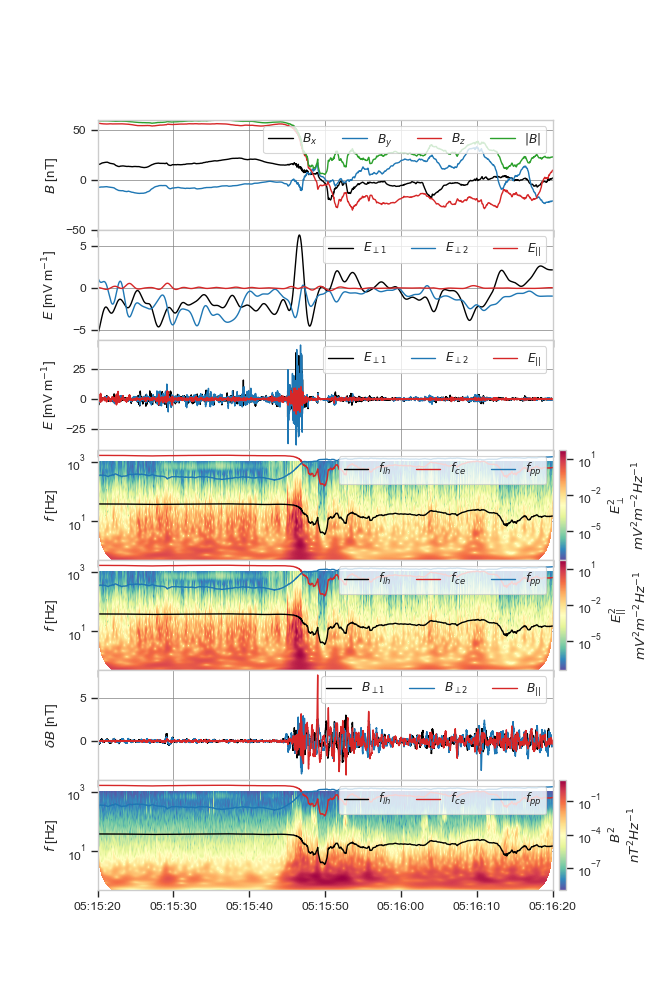

(735901.2189814815, 735901.2196759259)

In [11]:
%matplotlib notebook
f, axs = plt.subplots(7, sharex="all", figsize=(6.5,10))
f.subplots_adjust(left=.15, right=.85, hspace=0)
plot_line(axs[0], b_xyz)
plot_line(axs[0], b_mag)

axs[0].set_ylabel("$B$ [nT]")
axs[0].set_ylim([-50, 60])
axs[0].legend(["$B_{x}$","$B_{y}$","$B_{z}$","$|B|$"], **legend_options)

plot_line(axs[1], e_xyzfac_lf)
axs[1].set_ylabel("$E$ [mV m$^{-1}$]")
axs[1].legend(["$E_{\\perp 1}$","$E_{\\perp 2}$","$E_{||}$"], **legend_options)

plot_line(axs[2], e_xyzfac_hf)
axs[2].set_ylabel("$E$ [mV m$^{-1}$]")
axs[2].legend(["$E_{\\perp 1}$","$E_{\\perp 2}$","$E_{||}$"], **legend_options)

axs[3], caxs3 = plot_spectr(axs[3], e_perp_cwt, **spectr_options)
axs[3].set_ylabel("$f$ [Hz]")
caxs3.set_ylabel("$E_{\\perp}^2$" + "\n" + "$mV^2 m^{-2} Hz^{-1}$")
plot_line(axs[3], f_lh, "k")
plot_line(axs[3], f_ce, "tab:red")
plot_line(axs[3], f_pp, "tab:blue")
axs[3].legend(["$f_{lh}$", "$f_{ce}$", "$f_{pp}$"], **legend_options)

axs[4], caxs4 = plot_spectr(axs[4], e_perp_cwt, **spectr_options)
axs[4].set_ylabel("$f$ [Hz]")
caxs4.set_ylabel("$E_{||}^2$" + "\n" + "$mV^2 m^{-2} Hz^{-1}$")
plot_line(axs[4], f_lh, "k")
plot_line(axs[4], f_ce, "tab:red")
plot_line(axs[4], f_pp, "tab:blue")
axs[4].legend(["$f_{lh}$", "$f_{ce}$", "$f_{pp}$"], **legend_options)

plot_line(axs[5], b_scmfac_hf)
axs[5].set_ylabel("$\\delta B$ [nT]")
axs[5].legend(["$B_{\\perp 1}$","$B_{\\perp 2}$","$B_{||}$"], **legend_options)

axs[6], caxs6 = plot_spectr(axs[6], b_cwt, **spectr_options)
axs[6].set_ylabel("$f$ [Hz]")
caxs6.set_ylabel("$B^2$" + "\n" + "$nT^2 Hz^{-1}$")
plot_line(axs[6], f_lh, "k")
plot_line(axs[6], f_ce, "tab:red")
plot_line(axs[6], f_pp, "tab:blue")
axs[6].legend(["$f_{lh}$", "$f_{ce}$", "$f_{pp}$"], **legend_options)

f.align_ylabels(axs)
axs[-1].set_xlim(tint)